# Importation des packages

In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import random

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

from sklearn.utils import class_weight


# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Importe les données sources :

(Si vous avez préparer les données en amonts, vous pouvez directement aller à la partie [Vectorisation des données](#scrollTo=rgzmbm-XYGQm).


In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/test.csv')
data_test_labels = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/test_labels.csv')
data_test = pd.merge(data_test, data_test_labels, on = ['id'])

# Etude du jeu de données

## a. Les données d'entraînement

In [ ]:
data_train[50:60]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
50,001d8e7be417776a,"""\n\nBI, you said you wanted to talk\n\nAt the...",0,0,0,0,0,0
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0
52,001e89eb3f0b0915,Are you threatening me for disputing neutralit...,0,0,0,0,0,0
53,001ee16c46a99262,Thanks! Undeletion was more than I'd hoped for...,0,0,0,0,0,0
54,001ffdcc3e7fb49c,Awesome! Then I'll simply disregard your notic...,0,0,0,0,0,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
56,0020fd96ed3b8c8b,=Tony Sidaway is obviously a fistfuckee. He lo...,1,0,1,0,1,0
57,00218d74784ce50b,"""\n\n GA Review II \n\nI'm sorry to say this, ...",0,0,0,0,0,0
58,0021fe88bc4da3e6,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0
59,002264ea4d5f2887,Why can't you believe how fat Artie is? Did yo...,1,0,0,0,0,0


Commentaires type :

In [ ]:
data_train['comment_text'][57]

'"\n\n GA Review II \n\nI\'m sorry to say this, but I have to fail this article\'s GAN. The several major problems that  brought up in this article\'s previous GA assessment have not been issued. As s/he has said before me, ""he article\'s WP:LEAD should be longer. The History, Media attention, Academics, Student Government, Demographics, Trivia, and Additional Information section are very deficient in citiations. Also, Triva and Additional information should be integrated into the rest of the article."" Again, please look over WP:WIAGA and fix these problem, then renominate it for GA-class. However, I have re-assessed this article as B-class, as it does meet B-class criteria. My regards,   "'

In [ ]:
data_train['comment_text'][50:60]

50    "\n\nBI, you said you wanted to talk\n\nAt the...
51    GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK T...
52    Are you threatening me for disputing neutralit...
53    Thanks! Undeletion was more than I'd hoped for...
54    Awesome! Then I'll simply disregard your notic...
55    Stupid peace of shit stop deleting my stuff as...
56    =Tony Sidaway is obviously a fistfuckee. He lo...
57    "\n\n GA Review II \n\nI'm sorry to say this, ...
58    My Band Page's deletion. You thought I was gon...
59    Why can't you believe how fat Artie is? Did yo...
Name: comment_text, dtype: object

Proportion de données toxique dans les données d'entrainement :

In [ ]:
number_of_lines = data_train['toxic'].count()
print('Nombre de donnée totale : ', number_of_lines)

Nombre de donnée totale :  159571


In [ ]:
print( "Proportion de données toxique dans les données d'entrainement (en nombre) :\n",
      data_train.drop(columns=['id', 'comment_text']).sum()
)

Proportion de données toxique dans les données d'entrainement (en nombre) :
 toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [ ]:
print( "Proportion de données toxique dans les données d'entrainement (en pourcentage) :\n",
      (data_train.drop(columns=['id', 'comment_text']).sum() / number_of_lines * 100 ).round(3)
)

Proportion de données toxique dans les données d'entrainement (en pourcentage) :
 toxic            9.584
severe_toxic     1.000
obscene          5.295
threat           0.300
insult           4.936
identity_hate    0.880
dtype: float64


## b. Les données de test

On fait les mêmes analyses pour les données de test.

In [ ]:
data_test[50:60]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
50,001421530a1aa622,I have been perfectly civil in what quite clea...,-1,-1,-1,-1,-1,-1
51,001426f56de6a49b,*I agree with Billfruge. The author describes ...,0,0,0,0,0,0
52,00148cabab3f0abd,==Category:Italian Jews== \n\n :Category:Itali...,-1,-1,-1,-1,-1,-1
53,0015d9af6dbc03c0,== Someday Never == \n\n Why was the image del...,-1,-1,-1,-1,-1,-1
54,00166b5f5bf2d758,""", 5 December 2012 (UTC) \n\n :::The above is,...",-1,-1,-1,-1,-1,-1
55,0016909ad784fe8d,""":I see that you moved to Talat Hamdani. Perh...",-1,-1,-1,-1,-1,-1
56,0016b94c8b20ffa6,I WILL BURN YOU TO HELL IF YOU REVOKE MY TALK ...,0,0,0,0,0,0
57,0016ec04bb0f869a,== Hebrean-Judeo-Christian == \n\n What is Heb...,-1,-1,-1,-1,-1,-1
58,00177176f33f587e,== Can you work your magic? == \n\n Hi. I was...,0,0,0,0,0,0
59,0017d4d47894af05,":Fuck off, you anti-semitic cunt. |",1,0,1,0,1,0


La valeur -1 que l’on peut retrouver sur certain ligne indique que le commentaire n’a pas été utilisé. On les supprimera lors de la préparation des données.

Commentaires type :

In [ ]:
data_test['comment_text'][58]

"== Can you work your magic? == \n\n Hi.  I was wondring if you had time to help out with Wikipedia:Featured article candidates/W. E. B. Du Bois/archive1.  Any input would be appreciated:  a quick scan or a full review.  I've noticed your work before and I respect your skills. Thanks."

In [ ]:
data_test['comment_text'][50:60]

50    I have been perfectly civil in what quite clea...
51    *I agree with Billfruge. The author describes ...
52    ==Category:Italian Jews== \n\n :Category:Itali...
53    == Someday Never == \n\n Why was the image del...
54    ", 5 December 2012 (UTC) \n\n :::The above is,...
55    ":I see that you moved  to Talat Hamdani. Perh...
56    I WILL BURN YOU TO HELL IF YOU REVOKE MY TALK ...
57    == Hebrean-Judeo-Christian == \n\n What is Heb...
58    == Can you work your magic? == \n\n Hi.  I was...
59                 :Fuck off, you anti-semitic cunt.  |
Name: comment_text, dtype: object

Proportion de données toxique dans les données de test :

In [ ]:
number_of_lines = data_test['toxic'].count()
print('Nombre de donnée totale : ', number_of_lines)

Nombre de donnée totale :  153164


In [ ]:
print( "Proportion de données toxique dans les données de test (en nombre) :\n",
      data_test.drop(columns=['id', 'comment_text'])[data_test['toxic'] > 0].sum()
)

Proportion de données toxique dans les données de test (en nombre) :
 toxic            6090
severe_toxic      367
obscene          3626
threat            205
insult           3342
identity_hate     693
dtype: int64


In [ ]:
print( "Proportion de données toxique dans les données de test (en pourcentage) :\n",
      (data_test.drop(columns=['id', 'comment_text'])[data_test['toxic'] > 0].sum() / number_of_lines * 100 ).round(3)
)

Proportion de données toxique dans les données de test (en pourcentage) :
 toxic            3.976
severe_toxic     0.240
obscene          2.367
threat           0.134
insult           2.182
identity_hate    0.452
dtype: float64


# Préparation des données

## Création des fonctions

Récupère les stopwords et le tokenizer

In [ ]:
tokenizer = TweetTokenizer(strip_handles=True)
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
corpus = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


On crée une fonction prepare_string() pour nettoyer facilement les commentaires (retirer les abbréviations, homogénéiser les expressions, etc…) 

In [ ]:
def clean(tweet): 
            
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)  
    
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"yrs", "years", tweet)
    tweet = re.sub(r"hrs", "hours", tweet)
    tweet = re.sub(r"2morow|2moro", "tomorrow", tweet)
    tweet = re.sub(r"2day", "today", tweet)
    tweet = re.sub(r"4got|4gotten", "forget", tweet)
    tweet = re.sub(r"b-day|bday", "b-day", tweet)
    tweet = re.sub(r"mother's", "mother", tweet)
    tweet = re.sub(r"mom's", "mom", tweet)
    tweet = re.sub(r"dad's", "dad", tweet)
    tweet = re.sub(r"hahah|hahaha|hahahaha", "haha", tweet)
    tweet = re.sub(r"lmao|lolz|rofl", "lol", tweet)
    tweet = re.sub(r"thanx|thnx", "thanks", tweet)
    tweet = re.sub(r"goood", "good", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    # Urls
    tweet = re.sub(r"http\S+", "", tweet)
    # Numbers
    tweet = re.sub(r'[0-9]', '', tweet)
    # Eliminating the mentions
    tweet = re.sub("(@[A-Za-z0-9_]+)","", tweet)
    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        tweet = tweet.replace(p, '')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')
        
    # Tokenize
    tweet_words = tokenizer.tokenize(tweet)
    
    # Eliminating the word if its length is less than 3
    tweet = [w for w in tweet_words if len(w)>2]
    
    # remove stopwords
    tweet = [w.lower() for w in tweet if not w in stop_words]  
    
    corpus.append(tweet)
    
    # join back
    tweet = ' '.join(tweet)
        
        
    return tweet

In [ ]:
variable_name = ""
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev_in_text(tweet):
    t=[]
    words=tweet.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t) 

In [ ]:
def prepare_string(tweet):
  tweet = clean(tweet)
  tweet = convert_abbrev_in_text(tweet)
  return tweet

## Nettoyage des données

La colonne id n’étant pas utile pour notre entrainement, on ne la prend pas dans ces varibles.

In [ ]:
data_train.drop(columns=["id"], inplace=True)
data_test.drop(columns=["id"], inplace=True)

Comme on l’a vue durant l’étude des données, la valeur -1 que l’on peut retrouver sur certain ligne des données de testes indique que le commentaire n’a pas été utilisé et on ne les utilisera donc pas.

In [ ]:
data_test.drop( 
    data_test[ data_test['toxic'] == -1 ].index,
    inplace = True
)
data_test.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,:Dear god this site is horrible.,0,0,0,0,0,0
11,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


On utilise la fonction prepare_strings sur les données d’entrainement pour enlever les abbréviations, etc...

In [ ]:
%%time
# Apply prepare_string to all rows in 'tweets' column
data_train['comment_text'] = data_train['comment_text'].apply(lambda s : prepare_string(s))

# Drop empty values from dataframe
data_train['comment_text'].replace('', np.nan, inplace=True)
data_train.dropna(subset=['comment_text'], inplace=True)
print("\nExemple: ",data_train['comment_text'][57])


Exemple:  review sorry say fail articles gan the several major problems brought articles previous assessment issued said articles wplead longer the history media attention academics student government demographics trivia additional information section deficient citiations also triva additional information integrated rest article again please look wpwiaga fix problem renominate gaclass however reassessed article bclass meet bclass criteria regards
CPU times: user 1min 37s, sys: 480 ms, total: 1min 38s
Wall time: 1min 39s


De même pour les données de testes.

In [ ]:
%%time
# Apply prepare_string to all rows in 'tweets' column
data_test["comment_text"] = data_test["comment_text"].apply(lambda s : prepare_string(s))

# Drop empty values from dataframe
data_test.replace('', np.nan, inplace=True)
data_test.dropna(subset=['comment_text'], inplace=True)
print("\nExemple: ",data_test['comment_text'][58])


Exemple:  can work magic wondring time help wikipediafeatured article candidatesw boisarchive any input would appreciated quick scan full review noticed work respect skills thanks
CPU times: user 38.2 s, sys: 169 ms, total: 38.4 s
Wall time: 38.9 s


On enregistre les données pour ne pas avoir à les préparer de nouveau.

In [ ]:
data_train.to_csv('/content/drive/MyDrive/toxic_comment_classification/cleaned_comments_train.csv', index=False)
data_test.to_csv('/content/drive/MyDrive/toxic_comment_classification/cleaned_comments_test.csv', index=False)

## Vectorisation des données

Si on ne vient pas de préparer les données et que l’on souhaite récupérer les données précédemment préparées.

In [12]:
data_train = pd.read_csv('/content/drive/MyDrive/toxic_comment_classification/cleaned_comments_train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/toxic_comment_classification/cleaned_comments_test.csv')
data_train[50:60]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
50,said wanted talk bottom lead section written i...,0,0,0,0,0,0
51,get fucked get fuckeeed got drink that you can...,1,0,1,0,0,0
52,are threatening disputing neutrality know coun...,0,0,0,0,0,0
53,thanks undeletion would hoped researching stat...,0,0,0,0,0,0
54,awesome then simply disregard notice thanks,0,0,0,0,0,0
55,stupid peace shit stop deleting stuff asshole ...,1,1,1,0,1,0
56,tony sidaway obviously fistfuckee loves arm ass,1,0,1,0,1,0
57,review sorry say fail articles gan the several...,0,0,0,0,0,0
58,band pages deletion you thought gone deleting ...,1,0,1,0,0,0
59,why cannot believe fat artie did see recent ap...,1,0,0,0,0,0


In [13]:
data_train[50:60]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
50,said wanted talk bottom lead section written i...,0,0,0,0,0,0
51,get fucked get fuckeeed got drink that you can...,1,0,1,0,0,0
52,are threatening disputing neutrality know coun...,0,0,0,0,0,0
53,thanks undeletion would hoped researching stat...,0,0,0,0,0,0
54,awesome then simply disregard notice thanks,0,0,0,0,0,0
55,stupid peace shit stop deleting stuff asshole ...,1,1,1,0,1,0
56,tony sidaway obviously fistfuckee loves arm ass,1,0,1,0,1,0
57,review sorry say fail articles gan the several...,0,0,0,0,0,0
58,band pages deletion you thought gone deleting ...,1,0,1,0,0,0
59,why cannot believe fat artie did see recent ap...,1,0,0,0,0,0


On séparer d’abord les commentaires et les catégories dans deux varibles différentes (X_train et y_train). 

In [14]:
X_train = data_train['comment_text']
y_train = data_train.drop(columns=['comment_text'])
X_test = data_test['comment_text']
y_test = data_test.drop(columns=['comment_text'])

Puis on transforme les commentaires en vecteur de mots.

In [15]:
tfIdfVectorizer = TfidfVectorizer()
X_train_vect = tfIdfVectorizer.fit_transform(X_train)
X_test_vect = tfIdfVectorizer.transform(X_test)

# Entraînement du modèle baseline

On commence par un modèle simple de random forest.

Préparation du modèle :

In [16]:
# Use only 15 estimator to save your ram
text_classifier = RandomForestClassifier(
    n_estimators = 15,
    max_depth = 100,
    random_state = 0
)

Entrainement du modèle

In [17]:
text_classifier.fit(X_train_vect, y_train)

RandomForestClassifier(max_depth=100, n_estimators=15, random_state=0)

Teste du modèle

In [18]:
predictions = text_classifier.predict(X_test_vect)

On affiche les résultats des mesures de performences :

In [19]:
#print(confusion_matrix(y, predictions))

print(classification_report(y_test, predictions))

print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.06      0.11      6087
           1       1.00      0.01      0.01       367
           2       0.94      0.05      0.09      3688
           3       0.00      0.00      0.00       211
           4       0.92      0.03      0.05      3424
           5       1.00      0.00      0.00       712

   micro avg       0.93      0.04      0.08     14489
   macro avg       0.80      0.02      0.04     14489
weighted avg       0.92      0.04      0.08     14489
 samples avg       0.01      0.00      0.00     14489

0.9024940115541779


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Itération de la modélisation 

Deep learning model

## LSTM

[('explanation why edits made username hardcore metallica fan reverted they vandalisms closure gas voted new york dolls fac and please remove template talk page since retired', array([0, 0, 0, 0, 0, 0])), ('daww matches background colour seemingly stuck thanks talk january coordinated universal time', array([0, 0, 0, 0, 0, 0])), ('hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info', array([0, 0, 0, 0, 0, 0])), ('more cannot make real suggestions improvement wondered section statistics later subsection types accidents think references may need tidying exact format date format and so on later noone else first preferences formatting style references want please let know there appears backlog articles review guess may delay reviewer turns listed relevant form wikipediagoodarticlenominationstransport', array([0, 0, 0, 0, 0, 0])), ('you sir hero any chance remember page', array([0, 0, 0, 0, 0, 0]))]
Ep

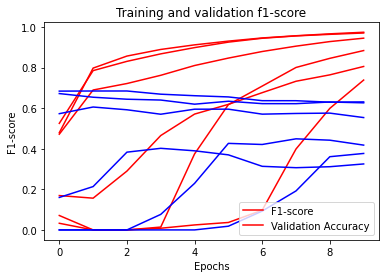

<Figure size 432x288 with 0 Axes>

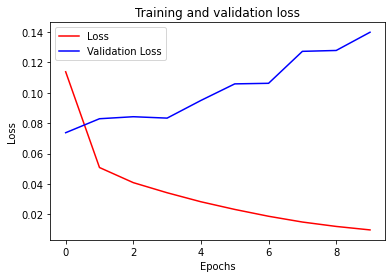

<Figure size 432x288 with 0 Axes>

In [ ]:
# Creation of tuples (tweet, label) in anticipation of data mixing
corpus = list(zip(data_train['comment_text'].values, data_train[["toxic","severe_toxic","obscene","threat", "insult", "identity_hate"]].values))

print(corpus[:5])

embedding_dim = 100    # Dimensions used for glove6b100
max_length = 20        # Maximum size of a tweet
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(corpus)
test_portion=.025

sentences=[]
labels=[]

for x in range(len(corpus)):
    sentences.append(str(corpus[x][0]))
    labels.append(corpus[x][1])

tokenizerDL = Tokenizer()
tokenizerDL.fit_on_texts(sentences)

word_index = tokenizerDL.word_index
vocab_size=len(word_index)

train_sequences = tokenizerDL.texts_to_sequences(sentences)
training_padded = np.array(pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type))

val_corpus = list(zip(data_test['comment_text'].values, data_test[["toxic","severe_toxic","obscene","threat", "insult", "identity_hate"]].values))

val_sentences=[]
val_labels=[]

for x in range(len(val_corpus)):
    val_sentences.append(str(val_corpus[x][0]))
    val_labels.append(val_corpus[x][1])

test_sequences = tokenizerDL.texts_to_sequences(val_sentences)
testing_padded = np.array(pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type))

num_epochs = 10
training_labels = np.array(labels)
test_labels = np.array(val_labels)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    LSTM(units=64),
    tf.keras.layers.Dense(6, activation='sigmoid')
])


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tfa.metrics.F1Score(num_classes=6, threshold=0.5)])

history = model.fit(training_padded, 
                      training_labels, 
                      epochs=num_epochs, 
                      validation_data=(testing_padded, test_labels),
                      batch_size = 256,
                      verbose=1)
  
print("Training Complete")

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['f1_score']
val_acc=history.history['val_f1_score']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation f1-score')
plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.legend(["F1-score", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

# Max length = 30

In [ ]:
max_length = 30

train_sequences = tokenizerDL.texts_to_sequences(sentences)
training_padded = np.array(pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type))

test_sequences = tokenizerDL.texts_to_sequences(val_sentences)
testing_padded = np.array(pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type))

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    LSTM(units=64),
    tf.keras.layers.Dense(6, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tfa.metrics.F1Score(num_classes=6, threshold=0.5)])

In [ ]:
history2 = model.fit(training_padded, 
                      training_labels, 
                      epochs=num_epochs, 
                      validation_data=(testing_padded, test_labels),
                      batch_size = 256,
                      verbose=1)
  
print("Training Complete")

Epoch 1/10
624/624 [==============================] - 62s 96ms/step - loss: 0.1462 - f1_score: 0.0385 - val_loss: 0.1019 - val_f1_score: 0.2784
Epoch 2/10
624/624 [==============================] - 18s 29ms/step - loss: 0.0599 - f1_score: 0.3591 - val_loss: 0.0710 - val_f1_score: 0.3271
Epoch 3/10
624/624 [==============================] - 14s 22ms/step - loss: 0.0430 - f1_score: 0.4477 - val_loss: 0.0805 - val_f1_score: 0.3817
Epoch 4/10
624/624 [==============================] - 12s 19ms/step - loss: 0.0353 - f1_score: 0.4954 - val_loss: 0.0802 - val_f1_score: 0.3894
Epoch 5/10
624/624 [==============================] - 9s 15ms/step - loss: 0.0302 - f1_score: 0.5258 - val_loss: 0.0856 - val_f1_score: 0.3748
Epoch 6/10
624/624 [==============================] - 11s 18ms/step - loss: 0.0255 - f1_score: 0.6021 - val_loss: 0.0910 - val_f1_score: 0.4226
Epoch 7/10
624/624 [==============================] - 10s 15ms/step - loss: 0.0210 - f1_score: 0.6790 - val_loss: 0.1091 - val_f1_score: 

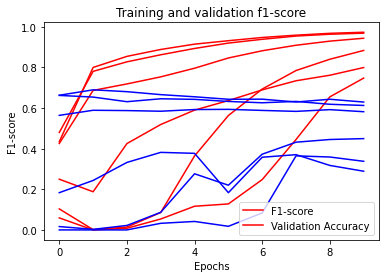

<Figure size 432x288 with 0 Axes>

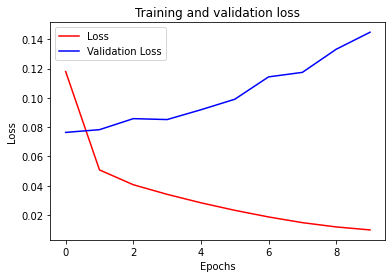

<Figure size 432x288 with 0 Axes>

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['f1_score']
val_acc=history.history['val_f1_score']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation f1-score')
plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.legend(["F1-score", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

# Limiter le bag of word à 20000

[('explanation why edits made username hardcore metallica fan reverted they vandalisms closure gas voted new york dolls fac and please remove template talk page since retired', array([0, 0, 0, 0, 0, 0])), ('daww matches background colour seemingly stuck thanks talk january coordinated universal time', array([0, 0, 0, 0, 0, 0])), ('hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info', array([0, 0, 0, 0, 0, 0])), ('more cannot make real suggestions improvement wondered section statistics later subsection types accidents think references may need tidying exact format date format and so on later noone else first preferences formatting style references want please let know there appears backlog articles review guess may delay reviewer turns listed relevant form wikipediagoodarticlenominationstransport', array([0, 0, 0, 0, 0, 0])), ('you sir hero any chance remember page', array([0, 0, 0, 0, 0, 0]))]
Ep

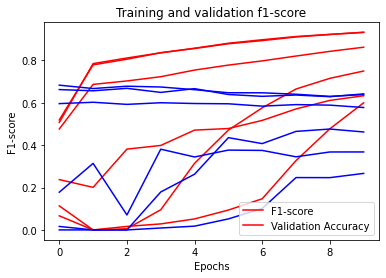

<Figure size 432x288 with 0 Axes>

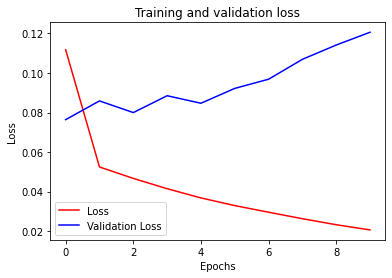

<Figure size 432x288 with 0 Axes>

In [ ]:
# Creation of tuples (tweet, label) in anticipation of data mixing
corpus = list(zip(data_train['comment_text'].values, data_train[["toxic","severe_toxic","obscene","threat", "insult", "identity_hate"]].values))

print(corpus[:5])

embedding_dim = 100    # Dimensions used for glove6b100
max_length = 20        # Maximum size of a tweet
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(corpus)
test_portion=.025

sentences=[]
labels=[]

for x in range(len(corpus)):
    sentences.append(str(corpus[x][0]))
    labels.append(corpus[x][1])

tokenizerDL = Tokenizer(20000)
tokenizerDL.fit_on_texts(sentences)

word_index = tokenizerDL.word_index
vocab_size=len(word_index)

train_sequences = tokenizerDL.texts_to_sequences(sentences)
training_padded = np.array(pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type))

val_corpus = list(zip(data_test['comment_text'].values, data_test[["toxic","severe_toxic","obscene","threat", "insult", "identity_hate"]].values))

val_sentences=[]
val_labels=[]

for x in range(len(val_corpus)):
    val_sentences.append(str(val_corpus[x][0]))
    val_labels.append(val_corpus[x][1])

test_sequences = tokenizerDL.texts_to_sequences(val_sentences)
testing_padded = np.array(pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type))

num_epochs = 10
training_labels = np.array(labels)
test_labels = np.array(val_labels)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(20001, embedding_dim, input_length=max_length),
    LSTM(units=64),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tfa.metrics.F1Score(num_classes=6, threshold=0.5)])

history = model.fit(training_padded, 
                      training_labels, 
                      epochs=num_epochs, 
                      validation_data=(testing_padded, test_labels),
                      batch_size = 256,
                      verbose=1)
  
print("Training Complete")

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['f1_score']
val_acc=history.history['val_f1_score']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation f1-score')
plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.legend(["F1-score", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

In [ ]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 20, 100)           2000000   
                                                                 
 lstm_20 (LSTM)              (None, 64)                42240     
                                                                 
 dense_20 (Dense)            (None, 6)                 390       
                                                                 
Total params: 2,042,630
Trainable params: 2,042,630
Non-trainable params: 0
_________________________________________________________________


In [ ]:
vocab_size

217806

## Utilisation matrice d'embedding (Glove)

In [ ]:
embeddings_index = {};

with open('/content/drive/MyDrive/RNN_sentiment_dataset/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [ ]:
modelEmbedding = tf.keras.Sequential([
    tf.keras.layers.Embedding(20001, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    LSTM(units=64),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

ValueError: ignored

In [ ]:
modelEmbedding.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tfa.metrics.F1Score(num_classes=6, threshold=0.5)])

In [ ]:
modelEmbedding.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 20, 100)           21780700  
                                                                 
 lstm_21 (LSTM)              (None, 64)                42240     
                                                                 
 dense_21 (Dense)            (None, 6)                 390       
                                                                 
Total params: 21,823,330
Trainable params: 42,630
Non-trainable params: 21,780,700
_________________________________________________________________


In [ ]:
history = modelEmbedding.fit(training_padded, 
                      training_labels, 
                      epochs=num_epochs, 
                      validation_data=(testing_padded, test_labels),
                      batch_size = 256,
                      verbose=1)
  
print("Training Complete")

Epoch 1/10
624/624 [==============================] - 7s 8ms/step - loss: 0.0951 - f1_score: 0.2927 - val_loss: 0.0823 - val_f1_score: 0.2988
Epoch 2/10
624/624 [==============================] - 6s 9ms/step - loss: 0.0611 - f1_score: 0.3593 - val_loss: 0.0757 - val_f1_score: 0.3607
Epoch 3/10
624/624 [==============================] - 5s 8ms/step - loss: 0.0571 - f1_score: 0.4187 - val_loss: 0.0775 - val_f1_score: 0.4279
Epoch 4/10
624/624 [==============================] - 4s 7ms/step - loss: 0.0547 - f1_score: 0.4728 - val_loss: 0.0814 - val_f1_score: 0.4628
Epoch 5/10
624/624 [==============================] - 5s 8ms/step - loss: 0.0527 - f1_score: 0.4967 - val_loss: 0.0792 - val_f1_score: 0.4697
Epoch 6/10
624/624 [==============================] - 6s 10ms/step - loss: 0.0511 - f1_score: 0.5266 - val_loss: 0.0786 - val_f1_score: 0.4724
Epoch 7/10
624/624 [==============================] - 4s 7ms/step - loss: 0.0499 - f1_score: 0.5518 - val_loss: 0.0788 - val_f1_score: 0.5104
Epoch

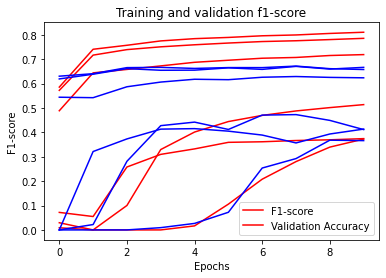

<Figure size 432x288 with 0 Axes>

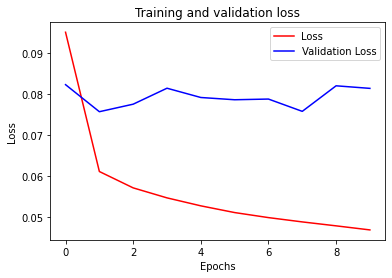

<Figure size 432x288 with 0 Axes>

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['f1_score']
val_acc=history.history['val_f1_score']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation f1-score')
plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.legend(["F1-score", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()